In [ ]:
!pip install openai --quiet
!pip install transformers --quiet
!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Loading Libraries

In [2]:
import pandas as pd
import numpy as np
import os
# from google.colab import userdata
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
# from openai import OpenAI
import random
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

c:\anaconda3\envs\torchdev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
client = OpenAI()

# Loading data

In [5]:
# df = pd.read_csv(
#     "bank_reviews3.csv"
# )
data = pd.read_csv(
    "../data/generated_bank_review.csv"
)

# Data preprocessing

In [6]:
data['rating'] = data['rating'].astype(int)

label_encoder = LabelEncoder()
data['rating'] = label_encoder.fit_transform(data['rating'])  # Convert ratings to class labels

train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['rating'])

val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['rating'])

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 3850
Validation set size: 825
Test set size: 825


In [7]:
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

train_dataset = train_dataset.rename_column("rating", "labels")
val_dataset = val_dataset.rename_column("rating", "labels")
test_dataset = test_dataset.rename_column("rating", "labels")

# Training

In [ ]:
model_name = "bert-base-uncased"  # Example pre-trained model suitable for sentiment tasks
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))




def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3850 [00:00<?, ? examples/s]

Map:   0%|          | 0/825 [00:00<?, ? examples/s]

Map:   0%|          | 0/825 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import DataCollatorWithPadding


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


In [ ]:
# step 7
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.863200,0.515502
2,0.384900,0.408819
3,0.251600,0.366929


TrainOutput(global_step=723, training_loss=0.49987908517671326, metrics={'train_runtime': 505.1349, 'train_samples_per_second': 22.865, 'train_steps_per_second': 1.431, 'total_flos': 3039041830809600.0, 'train_loss': 0.49987908517671326, 'epoch': 3.0})

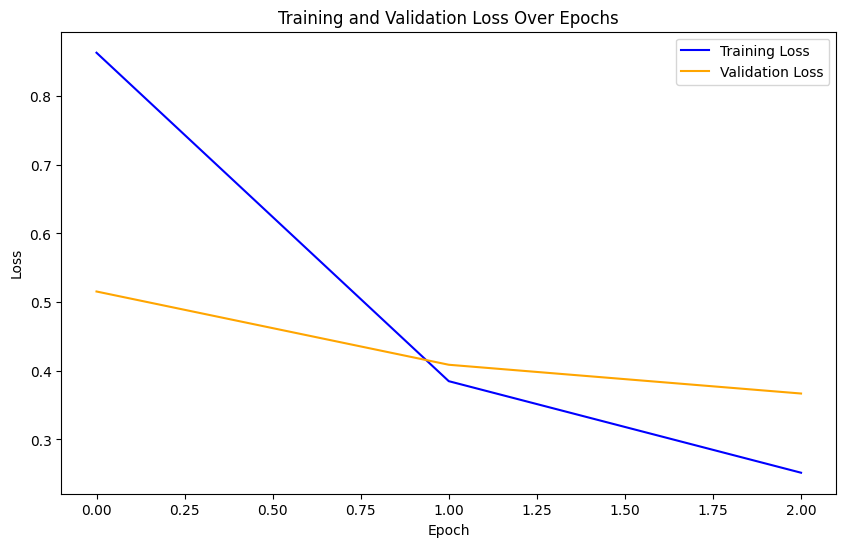

In [ ]:
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log and "eval_loss" not in log]
eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]


plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss", color='blue')
plt.plot(eval_loss, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

# Evaluation

In [ ]:
predictions = trainer.predict(test_dataset)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

accuracy = accuracy_score(labels, preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 88.85%


In [ ]:
model.save_pretrained("/content/drive/MyDrive/sentiment_analysis/bert_finetuned_model")
tokenizer.save_pretrained("/content/drive/MyDrive/sentiment_analysis/bert_finetuned_model")


('/content/drive/MyDrive/sentiment_analysis/bert_finetuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/sentiment_analysis/bert_finetuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/sentiment_analysis/bert_finetuned_model/vocab.txt',
 '/content/drive/MyDrive/sentiment_analysis/bert_finetuned_model/added_tokens.json',
 '/content/drive/MyDrive/sentiment_analysis/bert_finetuned_model/tokenizer.json')

# Load the Tuned-model

In [3]:
model_path = "./bert_finetuned_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


In [10]:
predictions = sentiment_pipeline(test_dataset['review'])

In [42]:
true  = test_dataset['labels']

In [ ]:
pred = []
for i in range(len(predictions)):
    label  = predictions[i]['label']
    int_label = int(label[-1])
    pred.append(int_label)

In [47]:
from sklearn.metrics import classification_report

In [50]:
cr = classification_report(true, pred)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93        83
           1       0.94      0.91      0.92       165
           2       0.90      0.93      0.91       165
           3       0.95      0.89      0.92       165
           4       0.98      0.76      0.85       165
           5       0.62      0.96      0.76        82

    accuracy                           0.89       825
   macro avg       0.89      0.90      0.88       825
weighted avg       0.91      0.89      0.89       825



In [ ]:
reviews = [
    "The bank's customer service was excellent and very helpful.",
    "I'm extremely disappointed with the loan approval process.",
]

predictions = sentiment_pipeline(reviews)

for review, pred in zip(reviews, predictions):
    print(f"Review: {review}")
    print(f"Predicted Rating: {pred['label']}, Confidence: {pred['score']:.2f}")
    print()


Review: The bank's customer service was excellent and very helpful.
Predicted Rating: LABEL_4, Confidence: 0.88

Review: I'm extremely disappointed with the loan approval process.
Predicted Rating: LABEL_1, Confidence: 0.70

